# Récupération d'une base de donnée

Dans ce notebook, nous allons récupérer les données issues de la BDD d'image de chiffre réalisé par Yann Lecun

In [1]:
import gzip
import numpy as np

file_image_train = gzip.open('bdd/train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 1000

file_image_train.read(16)
buf = file_image_train.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
vdata = data.reshape(num_images, image_size*image_size, 1)
data = data.reshape(num_images, image_size, image_size, 1)

file_label_train = gzip.open('bdd/train-labels-idx1-ubyte.gz','r')
file_label_train.read(8)
labels = []
for i in range(0,num_images):   
    buf = file_label_train.read(1)
    label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    labels.append(label)
    
vdata.shape

(1000, 784, 1)

In [2]:
file_image_verif = gzip.open('bdd/t10k-images-idx3-ubyte.gz','r')

image_size_verif = 28
num_images_verif = 10000

file_image_verif.read(16)
buf = file_image_verif.read(image_size * image_size * num_images)
data_verif = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
vdata_verif = data.reshape(num_images, image_size*image_size, 1)
data_verif = data.reshape(num_images, image_size, image_size, 1)

file_label_verif = gzip.open('bdd/t10k-labels-idx1-ubyte.gz','r')
file_label_verif.read(8)
labels_verif = []
for i in range(0,num_images_verif):   
    buf = file_label_verif.read(1)
    label_v = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    labels_verif.append(label_v)

<IPython.core.display.Javascript object>


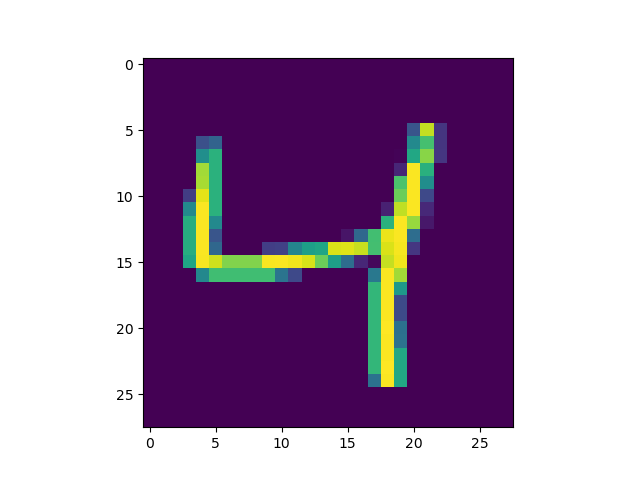

In [3]:
%matplotlib notebook 
import matplotlib.pyplot as plt

image = np.asarray(data[2]).squeeze()
plt.imshow(image, interpolation='none')
plt.show()

Afin d'éviter d'entrainer le réseau sur les mauvais paramètres, on va appliquer un filtre sur les images afin de les normaliser, dans un 1er temps cela consitera ne pas prendre en compte les niveaux de gris. (seulement 0 ou 255)

# Définition de l'algorithme

On commence par un réseau à 3 couches de 784 neurones pour les entrées, 15 dans la couche cachée et 10 en sortie
De plus, on définit les valeurs avec une loi gaussienne afin préparer la descente de gradiant

## Définition du réseaux : 

In [4]:
import numpy as np
import random

num_layers = 3  #3 couches
sizes = [784, 15, 10] #taille de chaque couche

biases = [np.random.randn(y, 1) for y in sizes[1:]] 
#génération des biais initiés à une valeur aléatoire suivant une loi gaussienne de moyenne 0 et variance 1
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
#génération des poids initiés à une valeur aléatoire suivant une loi gaussienne de moyenne 0 et variance 1

## Définition de la fonction d'activation et d'autres

In [5]:
#On commence par utiliser la fonction sigmoide comment fonction d'activation f(z) = 1/(1+e^-z)
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

In [6]:
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [7]:
#Retourne la sortie du réseau avec 'a' comme vecteur d'entrée
def feedforward(a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(biases, weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

## Définition des ensembles de données 

On adapte les données décompressées sous forme de matrice afin de les interpréter

In [8]:
#Cette fonction permet de redéfinir les labels en tant que vecteur correspondant on nombre de sortie du système,
#Chacune des 10 sorties représente un chiffre possible (0,1,2,3...,9)
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [9]:
#On commence par l'ensemble d'entrainement
#training_data = np.concatenate((data, labels),0)

training_data = []
training_data_verif = []
for i in range(0,num_images):
    training_data.append((vdata[i],vectorized_result(int(labels[i]))))
    training_data_verif.append((vdata_verif[i],int(labels_verif[i])))

## Apprentissage

Nous allons effectuer la descente de gradient à l'aide de la méthode stochastique sur plusieurs parties

In [10]:
def cost_derivative(output_activations, y):
        "Retourne la derivée partielle du coût par rapport aux activations"
        return (output_activations-y)

La fonction de backpropagation permet de trouver la variation nécessaire aux poids et biais du réseaux afin de se rapprocher des données d'entrainement. 
Elle fait 2 hypothèses :
La fonction de cout dépend des poids et biais du réseaux (ce qui est le cas pour le coût quadratique)
La fonction étant calculé par des dérivées partielles pour des entrainements différents se retrouve en faisant la moyenne de ces entrainements

L'objectif est donc de calculer les dérivées partielles de la fonction de coût en fonction des poids et des biais. 
Pour commencer on définit les activations de chaque couche en faisant les calculs matriciels. 
On obtient alors les activations de la derniere couche. 
Ensuite on calcul le vecteur d'erreur de la couche des sorties. 
Puis on utilise les formules de backpropagation pour faire propager cette erreur dans tout les poids du réseau jusqu'au 1er. 

In [11]:
def backprop(x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        # en sortie : le gradient de la fonction de cout, pour les poids et biais
        # pour chaque couche
        nabla_b = [np.zeros(b.shape) for b in biases]
        nabla_w = [np.zeros(w.shape) for w in weights]
        # on calcul les activations du réseau (notamment pour avoir la dernier couche d'activation)
        activation = x
        activations = [x] # on enregistre toutes les activations couche par couche
        zs = [] # on enregistre tout les valeurs de neurone (sans fonction d'activation) couche par couche
        for b, w in zip(biases, weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # on calcul l'erreur delta pour la dernière couche en multipliant sur les composantes la derivée partielle de
        # cout par rapport à l'activation et la derivée d'activation de la dernière couche (formule backpropagation n°1)
        delta = cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # on utilise la retropropagation pour trouver les erreurs des autres couches
        for l in range(2, num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

In [12]:
def update_mini_batch(mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The "mini_batch" is a list of tuples "(x, y)", and "eta"
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in biases]
        nabla_w = [np.zeros(w.shape) for w in weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        weights2 = [w-(eta/len(mini_batch))*nw for w, nw in zip(weights, nabla_w)]
        biases2 = [b-(eta/len(mini_batch))*nb for b, nb in zip(biases, nabla_b)]
        return (weights2, biases2)

In [13]:
def evaluate(test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

In [14]:
def SGD(training_data, epochs, mini_batch_size, eta, test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If "test_data" is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                weights, biases = update_mini_batch(mini_batch, eta)
            print(biases)
            print("Epoch n°" + str(j) + ", " + str(evaluate(training_data_verif)) + "/" + str(n_test))

In [15]:
num_layers = 3  #3 couches
sizes = [784, 15, 10] #taille de chaque couche
global biases
global weights
biases = [np.random.randn(y, 1) for y in sizes[1:]] 
#génération des biais initiés à une valeur aléatoire suivant une loi gaussienne de moyenne 0 et variance 1
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
#génération des poids initiés à une valeur aléatoire suivant une loi gaussienne de moyenne 0 et variance 1
SGD(training_data, 30, 10, 3.0, test_data=training_data_verif)

<ipython-input-5-4561056804e1>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


[array([[-0.46796229],
       [-1.22865898],
       [-1.33324806],
       [ 0.91332621],
       [ 0.5132501 ],
       [-1.30139803],
       [ 0.84779785],
       [-0.80695278],
       [-0.56553927],
       [ 0.30987595],
       [ 0.49142323],
       [-0.12691601],
       [ 2.48436045],
       [-0.53131423],
       [-0.1709807 ]]), array([[-1.06422566],
       [-3.63887834],
       [-0.09980666],
       [ 1.86285778],
       [-0.29850917],
       [ 0.48243985],
       [ 0.93442968],
       [-0.04181852],
       [ 0.24142921],
       [-1.00573408]])]
Epoch n°0, 95/1000
[array([[-0.46796229],
       [-1.22865898],
       [-1.33324806],
       [ 0.9133274 ],
       [ 0.51325002],
       [-1.30139803],
       [ 0.84779785],
       [-0.80695278],
       [-0.56553927],
       [ 0.30987595],
       [ 0.49142323],
       [-0.12691601],
       [ 2.48436045],
       [-0.53131423],
       [-0.1709807 ]]), array([[-0.93530448],
       [-3.61831832],
       [-0.04601349],
       [ 1.82533405],
     

[array([[-0.46796229],
       [-1.22865898],
       [-1.33324806],
       [ 0.91332621],
       [ 0.5132501 ],
       [-1.30139803],
       [ 0.83440172],
       [-0.80695278],
       [-0.56553927],
       [ 0.30987595],
       [ 0.49142323],
       [-0.12691601],
       [ 2.48436045],
       [-0.53131423],
       [-0.1709807 ]]), array([[-1.03696395],
       [-3.64079799],
       [-0.07689738],
       [ 1.82904083],
       [-0.29272201],
       [ 0.47004573],
       [ 0.88406008],
       [-0.1082908 ],
       [ 0.31373808],
       [-0.76306582]])]
Epoch n°16, 95/1000
[array([[-0.46796229],
       [-1.22865898],
       [-1.33324806],
       [ 0.91332621],
       [ 0.5132501 ],
       [-1.30139803],
       [ 0.84779785],
       [-0.80695278],
       [-0.56553927],
       [ 0.30987595],
       [ 0.49142323],
       [-0.12691601],
       [ 2.48436045],
       [-0.53131423],
       [-0.1709807 ]]), array([[-0.98013463],
       [-3.63502232],
       [-0.07592061],
       [ 1.79372742],
    

In [16]:
feedforward(vdata[0])

<ipython-input-5-4561056804e1>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


array([[0.98008873],
       [0.07150287],
       [0.27539479],
       [0.95053951],
       [0.00473869],
       [0.81205502],
       [0.2308935 ],
       [0.6842636 ],
       [0.59618989],
       [0.20165596]])

ERREUR, les poids et biais ne s'actualisent pas..